In [1]:
# This code works in Python 3.10.6
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
import torch_geometric.transforms as T
import networkx as nx
import seaborn as sns
import torch
import warnings
warnings.filterwarnings('ignore')

In [2]:
import csv
import os
import os.path as osp

## PubMed Dataset

In [3]:
df_nodes = pd.read_table(('node_pubmed.dat'),names=['node_id', 'node_name', 'node_type', 'node_attributes'],
                         quoting=csv.QUOTE_NONE)

In [4]:
df_labels_train = pd.read_table(('label_pubmed.dat'),
                                names=['node_id', 'node_name', 'node_type', 'node_label'])

In [5]:
df_labels_test = pd.read_table(('label_pubmed.dat.test'),
                               names=['node_id', 'node_name', 'node_type', 'node_label'])

In [6]:
df_labels = pd.concat([df_labels_train, df_labels_test],ignore_index=True)
df_labels.head()

,node_id,node_name,node_type,node_label
0,46178,psoriasis,1,6
1,60275,Skin_disease,1,6
2,16406,Nevus,1,6
3,52160,frambesia,1,6
4,46120,Erythroderma,1,6


In [7]:
#Select the nodes of type 1 which are labeled
df_disease=pd.merge(df_nodes, df_labels, on="node_id")[['node_id','node_attributes','node_label']]
df_disease = df_disease.reset_index()
df_disease.head()

,index,node_id,node_attributes,node_label
0,0,81,"0.293945,-1.118894,0.365789,0.826958,-1.024909...",2
1,1,382,"-0.076263,-0.1012,0.205599,-0.010939,0.011885,...",0
2,2,719,"-0.00509,-0.093002,0.155948,-1.041911,-0.11497...",1
3,3,1168,"-1.590567,-1.421712,1.546614,2.070439,-1.26965...",5
4,4,1183,"-0.047317,-0.141594,0.075213,-0.12674,-0.05318...",4


### Continuous features of 8 Disease node classes

In [8]:
def convert_string_to_float(df):
    return df['node_attributes'].apply(lambda x: np.fromstring(x, dtype=float, sep=',' ))

In [9]:
def preprocess_class(df_class):
    df_class = df_class.reset_index()
    df_class = convert_string_to_float(df_class)

    x = torch.tensor(df_class).float()
    disease_class = pd.DataFrame(x.numpy())
    return disease_class

In [10]:
class0 = df_disease[df_disease['node_label'] == 0].drop(['node_label','node_id'], axis = 1)
disease_class0 = preprocess_class(class0)
disease_class0.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.076263,-0.101200,0.205599,-0.010939,0.011885,-0.186806,0.017315,0.054221,-0.134682,0.029309,...,0.003725,-0.046961,0.022030,-0.059511,0.077090,0.027611,-0.119589,0.077600,-0.107299,0.150120
1,-0.105695,0.184201,-0.311365,-0.586918,0.041839,-0.375352,-0.209809,-0.275197,-0.187691,-0.010407,...,-0.295827,0.270551,0.139439,-0.118387,0.218033,0.240468,-0.405404,-0.024009,-0.038280,-0.079097
2,-0.027505,-0.145466,0.130640,-0.371549,0.082745,0.034039,-0.263921,0.326173,-0.230346,0.233040,...,-0.071879,-0.146309,0.144660,-0.052654,-0.092761,-0.082010,-0.002204,0.110625,-0.029077,-0.149880
3,-0.212835,0.020092,-0.067165,-0.360546,0.003719,-0.316084,-0.095670,-0.090671,-0.355869,0.123713,...,-0.042489,0.322580,0.213475,0.184327,0.126990,-0.174734,-0.356310,-0.022425,-0.208380,0.164806
4,0.176848,-0.177994,0.217688,-0.140722,-0.002420,-0.194984,-0.056105,0.126072,-0.111896,0.070906,...,-0.095619,-0.040588,0.164668,0.183074,-0.007102,-0.078018,-0.206885,-0.046569,-0.120863,0.097002


In [11]:
class1 = df_disease[df_disease['node_label'] == 1].drop(['node_label','node_id'], axis = 1)
disease_class1 = preprocess_class(class1)
disease_class1.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.005090,-0.093002,0.155948,-1.041911,-0.114979,-0.617497,0.166439,-0.113988,-0.443707,0.636185,...,-0.327394,0.439298,0.356134,0.690550,-0.308860,0.468901,0.244124,-0.058623,-0.368219,0.021397
1,0.678459,0.161107,-0.294408,-1.367651,2.103768,1.186129,1.882125,0.423219,-1.912892,1.194931,...,1.654857,1.608435,1.162236,-2.717319,-0.201214,1.197099,-1.264541,-2.922577,-1.188741,-1.307242
2,-1.681199,-0.703751,1.128087,-2.226594,-1.046119,0.636730,-0.500095,-0.239979,-0.998992,1.267447,...,2.065444,-1.046750,-2.627437,0.992201,0.717234,-2.367232,-2.050255,2.666933,-0.772199,0.401438
3,0.130749,-0.267213,1.721457,-0.982399,-0.044695,0.734526,-1.621730,0.373868,-0.232872,0.250372,...,-0.560398,0.781580,-0.162089,0.002168,0.013112,0.295674,-0.078259,0.097034,-0.650094,0.730890
4,0.465970,0.497691,-1.815122,-2.004339,-1.764053,-1.834500,0.539877,-1.023946,-1.697607,-0.490281,...,-0.737012,0.975823,-1.241157,0.261960,1.214548,-0.651538,-0.052915,-1.043717,-0.922041,1.584273


In [12]:
class2 = df_disease[df_disease['node_label'] == 2].drop(['node_label','node_id'], axis = 1)
disease_class2 = preprocess_class(class2)
disease_class2.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.293945,-1.118894,0.365789,0.826958,-1.024909,1.365870,-0.467886,0.515582,0.910748,1.669809,...,1.176890,-1.274171,-0.108948,-0.122850,0.121726,-0.147028,1.688417,-1.279368,-0.453393,-1.340375
1,-0.234695,-0.397418,-0.287049,-0.643192,-0.341378,-0.137831,0.152796,-0.083522,-0.232843,0.195185,...,0.211748,0.152090,0.104088,-0.103871,0.049093,0.222295,-0.139634,-0.290401,-0.421514,-0.226837
2,0.695679,-0.269031,-0.039114,-0.220264,0.207794,-0.019134,-0.248732,-0.059364,-0.408351,0.298378,...,0.260148,0.496637,-0.177052,-0.503436,0.183291,-0.307593,0.698607,0.043632,0.076104,0.478376
3,0.360314,-0.048848,0.084257,-0.308134,-0.118678,0.166424,-0.763351,0.002166,-0.790255,0.063675,...,-0.484946,0.004471,0.204809,-0.054277,0.325952,-0.179520,-0.097079,0.044739,-0.012146,-0.029781
4,-0.404648,-0.211988,0.180779,0.011021,0.246021,-0.108891,-0.292355,0.192935,-0.278896,0.114823,...,-0.048433,-0.053900,-0.057867,-0.046750,-0.020443,0.026236,-0.223835,-0.044477,-0.056810,-0.219431


In [13]:
class3 = df_disease[df_disease['node_label'] == 3].drop(['node_label','node_id'], axis = 1)
disease_class3 = preprocess_class(class3)
disease_class3.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.024643,0.083535,-0.118264,0.594446,-0.201284,-0.355791,-0.249425,0.963553,0.531981,0.146523,...,0.748214,0.242602,-0.510621,-1.191598,0.397599,-0.320266,0.024989,0.133490,1.125030,-0.851694
1,0.556467,-2.086023,1.777970,-0.953517,0.915395,1.392508,-1.678550,0.540311,1.287577,0.618743,...,-0.411275,0.044154,0.361089,-1.754970,0.017345,0.280704,-0.718187,-0.045025,-0.258995,-0.425449
2,0.399095,-0.033018,-0.050412,-0.308753,-0.270034,0.745800,0.109193,0.020682,0.472592,0.340427,...,0.173446,0.161498,0.315679,0.281295,-0.044803,0.013173,-0.458676,-0.137317,0.170523,0.214067
3,-0.240225,-1.536221,1.694471,0.427379,-1.573127,-1.249170,0.884610,0.263238,0.510730,1.645338,...,0.614007,0.541815,-2.998076,-2.450051,1.247795,-0.588532,3.193011,0.717154,0.347180,-1.627718
4,0.362348,-1.096200,0.676793,-0.413567,-0.772641,0.890930,-0.149459,0.236680,0.380899,0.178184,...,0.455985,-0.515523,0.660446,0.193103,0.302213,-0.151369,0.092068,0.212235,0.546388,0.454193


In [14]:
class4 = df_disease[df_disease['node_label'] == 4].drop(['node_label','node_id'], axis = 1)
disease_class4 = preprocess_class(class4)
disease_class4.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.047317,-0.141594,0.075213,-0.126740,-0.053180,-0.218182,0.010254,0.047152,-0.041381,0.002139,...,-0.163869,0.026139,0.029002,0.043187,0.089586,0.033324,-0.114441,-0.060817,-0.010271,0.124895
1,0.562200,-0.225132,1.403848,-0.900295,0.262917,0.775106,-1.395564,0.311257,-0.724682,0.510858,...,0.411451,0.706201,0.340969,0.616213,-0.581052,-0.016106,-0.312787,-0.254518,0.271065,-0.790870
2,0.132653,0.074229,0.130764,0.033300,-0.102414,-0.218270,-0.071465,0.149520,-0.059220,0.017269,...,-0.111331,0.032618,-0.101999,0.099495,0.009021,0.139706,-0.035738,0.021552,0.008510,0.002877
3,-0.017639,-0.033512,0.000192,-0.109765,0.026992,-0.011844,-0.011614,-0.025284,0.024664,0.010700,...,0.005757,0.102228,0.023747,0.007250,0.059213,0.070808,-0.047414,-0.096692,-0.043873,-0.066162
4,-0.131220,-0.051643,-0.041383,-0.281236,-0.046421,-0.136331,-0.069264,0.033541,-0.169223,0.180200,...,0.037729,-0.067685,0.098400,0.071199,0.224848,0.105085,-0.249451,-0.156987,-0.106818,0.112558


In [15]:
class5 = df_disease[df_disease['node_label'] == 5].drop(['node_label','node_id'], axis = 1)
disease_class5 = preprocess_class(class5)
disease_class5.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-1.590567,-1.421712,1.546614,2.070439,-1.269654,-3.492672,-0.985981,0.546692,-0.475412,-1.536833,...,0.422038,0.007902,-1.390627,-1.551006,0.566039,-0.957820,1.291253,-0.831003,-0.518681,-2.290930
1,1.707825,-0.382173,-1.978946,-0.982130,-0.596798,-1.058455,-0.786816,1.240825,-0.129001,0.208566,...,0.172373,3.154299,-0.672227,1.427703,1.280134,0.568588,-0.842362,-2.181951,1.627768,-0.607146
2,0.220100,-0.417449,-0.685131,0.271951,0.078659,-0.432255,0.099468,0.972583,0.090751,-0.106717,...,-0.402620,2.183498,-0.601318,1.458961,1.056984,0.751510,-1.148700,-1.398744,0.755516,-0.002951
3,-1.740684,0.606801,-1.877703,1.046687,0.026526,-0.971972,-0.062663,0.606383,-0.530064,-0.484855,...,0.776250,-1.420441,-0.033495,-0.917212,-0.367292,1.660141,-0.226066,1.478080,-0.249655,-0.803304
4,-0.115116,0.002367,-0.479038,-0.177523,0.033764,-0.129842,0.056449,-0.296631,-0.288493,-0.015120,...,-0.138466,-0.019240,-0.189517,-0.354875,0.412785,-0.289701,0.006733,0.096080,-0.055206,-0.724863


In [16]:
class6 = df_disease[df_disease['node_label'] == 6].drop(['node_label','node_id'], axis = 1)
disease_class6 = preprocess_class(class6)
disease_class6.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.705640,0.985807,1.727781,-0.572725,-1.510551,0.642899,-0.624731,-1.256330,0.380489,0.023940,...,0.237006,-0.864796,0.610489,0.725486,-0.615443,1.057366,-1.303320,-0.523200,-0.703197,0.300165
1,0.011111,-0.122398,0.108061,-0.168659,0.130440,-0.140680,-0.039575,0.006266,-0.134101,0.157674,...,-0.144526,0.049754,0.064575,0.282247,0.194395,0.082200,-0.225217,-0.088581,-0.127291,0.053279
2,1.179064,-0.248007,1.991181,0.059653,-1.148944,0.998520,-2.427823,0.023305,-1.135082,0.836730,...,0.554176,-0.339511,-0.320372,-0.973622,0.498973,0.603219,0.206073,-0.617010,0.398882,-0.659668
3,1.189486,-0.211165,1.973143,-0.170255,0.155388,0.033257,-1.330603,0.244563,-1.469571,0.941832,...,0.590651,-0.198665,0.922510,0.824605,-0.320789,-0.067372,-0.554014,-0.405515,-0.508741,-0.424119
4,0.355506,0.235083,0.229828,-0.683967,0.104608,-0.054153,-0.353290,-0.215031,-0.647038,0.664175,...,0.223206,-0.076717,0.368509,0.355019,-0.116577,0.160777,0.104109,-0.340245,-0.294386,0.067596


In [17]:
class7 = df_disease[df_disease['node_label'] == 7].drop(['node_label','node_id'], axis = 1)
disease_class7 = preprocess_class(class7)
disease_class7.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.008934,-0.107426,-0.025639,-0.182206,-0.061130,-0.204593,0.052291,0.000600,-0.019277,-0.035205,...,-0.004144,-0.114080,-0.111657,-0.027183,0.011316,0.052875,-0.172027,0.045929,-0.126126,0.006938
1,0.137979,-0.170588,0.379676,-0.133586,0.079844,-0.251604,-0.024294,-0.344566,0.012777,-0.011450,...,-0.218091,-0.112789,0.223476,0.009716,0.009727,-0.239896,-0.423860,0.127019,-0.208154,0.340889
2,-0.103373,-0.060679,0.032110,-0.060401,-0.028959,-0.040241,0.008029,0.002173,0.159710,0.096757,...,-0.051615,0.114342,-0.094867,0.182887,0.080529,0.035603,-0.051109,-0.036864,0.006196,-0.052524
3,-0.599056,-1.798572,0.036479,0.219410,-0.855767,-0.576619,1.906403,-1.219357,2.067185,-0.082776,...,0.970780,1.856780,-0.228110,0.857764,0.265307,0.256848,-0.150381,-0.285863,-1.042520,0.592658
4,1.363495,-0.065928,1.405803,-0.537324,-0.262326,-1.180556,0.268985,-0.565657,-0.405827,-1.344875,...,-0.853315,-0.385528,1.336321,0.695131,-0.434372,1.154994,0.586074,0.639965,-1.056659,-0.311664


### Feature selection from continuous features of Disease node using Correlation

In [18]:
corr = disease_class0.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.45).any()
real0 = corr.loc[m]
print('Index of the most uncorrelated feature',np.ravel(real0.index))
real_ind0 = real0.index[0]
imp_feat0 = corr[real_ind0].sort_values().head(9)
list0_index = np.ravel(imp_feat0.index).tolist()
list0_index.append(real_ind0)
imp_feat0 = disease_class0[list0_index]
imp_feat0.head()

Index of the most uncorrelated feature [193]


,66,155,113,18,119,107,174,159,134,193
0,0.030337,-0.067646,-0.106269,-0.193064,-0.002517,0.012773,-0.016571,0.007874,0.016483,-0.059511
1,-0.040625,0.096646,0.148626,0.155922,-0.310963,0.241434,-0.193628,0.048189,0.149476,-0.118387
2,0.224031,-0.316086,0.001034,-0.355765,0.215953,0.215266,0.002081,0.038715,0.053273,-0.052654
3,0.049968,-0.037611,0.036676,-0.056487,-0.256410,-0.057959,-0.165648,-0.118325,0.025515,0.184327
4,0.214466,0.077566,-0.040513,-0.166329,-0.032811,0.038589,-0.040555,-0.047611,-0.075000,0.183074


In [19]:
corr = disease_class1.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.45).any()
real1 = corr.loc[m]
print('Index of the most uncorrelated feature',np.ravel(real1.index))
real_ind1 = real1.index[0]
imp_feat1 = corr[real_ind1].sort_values().head(9)
list1_index = np.ravel(imp_feat1.index).tolist()
list1_index.append(real_ind1)
imp_feat1 = disease_class1[list1_index]
imp_feat1.head()

Index of the most uncorrelated feature [6]


,170,70,144,54,7,45,67,163,15,6
0,-0.084739,-0.075491,-0.205270,0.051392,-0.113988,0.701226,-0.315581,-0.234196,0.176917,0.166439
1,0.517269,-1.953127,-1.497746,0.931858,0.423219,-0.898935,-0.212057,0.059279,0.610486,1.882125
2,-0.406149,-0.175024,0.883339,-3.267881,-0.239979,1.440533,-1.195312,0.588961,0.110132,-0.500095
3,0.804124,0.014906,-0.061902,-0.041696,0.373868,1.539903,-0.360771,0.618287,0.793615,-1.621730
4,1.412346,-0.044802,-1.151178,-0.255165,-1.023946,1.879575,-1.833046,1.222715,0.295086,0.539877


In [20]:
corr = disease_class2.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.45).any()
real2 = corr.loc[m]
print('Index of the most uncorrelated feature',np.ravel(real2.index))
real_ind2 = real2.index[0]
imp_feat2 = corr[real_ind2].sort_values().head(9)
list2_index = np.ravel(imp_feat2.index).tolist()
list2_index.append(real_ind2)
imp_feat2 = disease_class2[list2_index]
imp_feat2.head()

Index of the most uncorrelated feature [17]


,43,68,24,61,169,149,28,138,53,17
0,0.992397,1.097218,1.003482,0.451635,0.703021,0.447734,0.585846,1.505129,-0.147736,-1.495274
1,-0.491742,-0.303415,0.204240,0.107761,-0.233279,-0.621874,0.074141,0.003502,0.147620,0.282449
2,-0.116147,-0.361876,-0.367811,0.017400,-0.666431,-0.222310,0.483036,-0.220880,-0.604320,0.684033
3,-0.656418,-0.318748,-0.762032,-0.403771,0.071751,0.009367,0.185311,-0.757174,0.656150,0.057979
4,-0.252085,-0.146912,0.036674,-0.000283,-0.241746,-0.202317,-0.158341,-0.054152,0.341173,-0.044009


In [21]:
corr = disease_class3.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.54).any()
real3 = corr.loc[m]
print('Index of the most uncorrelated feature',np.ravel(real3.index))
real_ind3 = real3.index[0]
imp_feat3 = corr[real_ind3].sort_values().head(9)
list3_index = np.ravel(imp_feat3.index).tolist()
list3_index.append(real_ind3)
imp_feat3 = disease_class3[list3_index]
imp_feat3.head()

Index of the most uncorrelated feature [149]


,172,9,107,87,142,27,32,98,94,149
0,-0.808473,0.146523,0.266402,-0.698287,0.592611,-0.193012,-0.051087,0.160698,0.892716,-0.125124
1,0.857907,0.618743,0.351659,-0.624908,-0.391443,-0.913990,-0.859669,0.694002,-0.086689,0.693438
2,-0.015280,0.340427,-0.213617,0.205117,-0.057150,-0.019265,-0.007013,-0.518363,-0.496819,-0.359230
3,-0.977818,1.645338,-1.520040,1.473708,1.163459,0.725651,-2.100256,-0.820114,0.116119,-0.186282
4,0.521554,0.178184,0.238511,-1.013341,0.179007,-0.837710,0.236879,0.392207,0.830978,-0.464164


In [22]:
corr = disease_class4.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.45).any()
real4 = corr.loc[m]
print('Index of the most uncorrelated feature',np.ravel(real4.index))
real_ind4 = real4.index[0]
imp_feat4 = corr[real_ind4].sort_values().head(9)
list4_index = np.ravel(imp_feat4.index).tolist()
list4_index.append(real_ind4)
imp_feat4 = disease_class4[list4_index]
imp_feat4.head()

Index of the most uncorrelated feature [73]


,71,147,0,198,111,182,126,12,151,73
0,-0.045473,0.083947,-0.047317,-0.010271,0.104782,0.034474,0.088554,-0.238804,0.046005,-0.020973
1,1.410357,1.176794,0.562200,0.271065,1.265940,-0.100260,1.048367,0.002572,0.643652,-0.703699
2,0.151705,0.316068,0.132653,0.008510,0.121836,-0.103081,0.080092,-0.123759,0.024263,-0.208185
3,0.016188,0.004742,-0.017639,-0.043873,-0.035586,0.085184,0.054886,-0.144102,0.005597,-0.012736
4,0.026731,0.140404,-0.131220,-0.106818,0.059618,0.112689,0.126476,-0.190867,-0.034019,-0.080110


In [23]:
corr = disease_class5.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.407).any()
real5 = corr.loc[m]
print('Index of the most uncorrelated feature',np.ravel(real5.index))
real_ind5 = real5.index[0]
imp_feat5 = corr[real_ind5].sort_values().head(9)
list5_index = np.ravel(imp_feat5.index).tolist()
list5_index.append(real_ind5)
imp_feat5 = disease_class5[list5_index]
imp_feat5.head()

Index of the most uncorrelated feature [159]


,88,121,2,64,81,42,34,114,19,159
0,0.855584,-0.143563,1.546614,1.218717,2.170044,2.714052,-1.316203,1.801585,0.263687,-1.361380
1,0.121108,-0.068539,-1.978946,-1.699386,-1.171167,-0.347786,-0.878527,-0.336793,0.188006,1.005774
2,0.269289,-0.320835,-0.685131,-1.403021,-0.785133,-0.569578,-0.608712,-0.407248,-0.186847,0.543750
3,0.002636,0.882292,-1.877703,-0.417736,1.002067,1.329749,0.138966,0.935233,0.105500,-0.814896
4,-0.573918,-0.233031,-0.479038,0.124680,-0.451993,0.080471,-0.089721,-0.022788,-0.026653,0.551804


In [24]:
corr = disease_class6.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.5).any()
real6 = corr.loc[m]
print('Index of the most uncorrelated feature',np.ravel(real6.index))
real_ind6 = real6.index[0]
imp_feat6 = corr[real_ind6].sort_values().head(9)
list6_index = np.ravel(imp_feat6.index).tolist()
list6_index.append(real_ind6)
imp_feat6 = disease_class6[list6_index]
imp_feat6.head()

Index of the most uncorrelated feature [91]


,99,12,58,59,81,4,43,69,40,91
0,-1.438364,-0.575606,0.158649,-0.521911,-1.380999,-1.510551,-1.365129,0.940127,-0.277415,0.388185
1,-0.156460,-0.180357,0.046295,-0.181370,-0.223718,0.130440,-0.202044,-0.135014,0.012691,-0.030215
2,-0.326667,-1.147588,-0.661336,-1.202884,-0.476360,-1.148944,-1.591620,0.455465,-0.389190,0.544368
3,-1.270364,-0.165499,-0.032017,-0.656045,-0.659873,0.155388,-0.348327,-0.299255,-0.266409,-0.023207
4,-0.583831,-0.454969,-0.116994,-0.240151,-0.734153,0.104608,0.011270,-0.409313,-0.228634,-0.113355


In [25]:
corr = disease_class7.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.54).any()
real7 = corr.loc[m]
print('Index of the most uncorrelated feature',np.ravel(real7.index))
real_ind7 = real7.index[0]
imp_feat7 = corr[real_ind7].sort_values().head(9)
list7_index = np.ravel(imp_feat7.index).tolist()
list7_index.append(real_ind7)
imp_feat7 = disease_class7[list7_index]
imp_feat7.head()

Index of the most uncorrelated feature [46]


,15,136,26,69,181,81,149,194,172,46
0,0.028601,0.085372,-0.099661,0.153093,-0.011682,-0.093633,-0.006690,0.011316,0.027622,-0.074768
1,0.704361,0.047332,0.169751,0.890707,0.368543,0.189666,0.180284,0.009727,-0.105864,-0.152452
2,-0.037440,-0.004984,-0.155382,0.021336,0.048048,-0.162602,-0.210028,0.080529,0.146376,0.133662
3,-0.463465,1.256697,0.280566,2.356831,1.402933,-0.622079,-0.334611,0.265307,0.157383,0.356692
4,0.832420,0.373131,1.502566,-0.323958,0.325022,-0.653413,-0.951429,-0.434372,-0.199047,-0.170141


### Discrete features of each class of Disease node are generated from Diffusion Models and converted to continuous by applying a threshold

In [26]:
import random
def apply_threshold(df):
    return df.applymap(lambda x: random.uniform(-1.0, 0.0) if x == 0.0 else random.uniform(0.1, 1.0))

In [27]:
syn0 = pd.DataFrame(torch.load('../sampled_features/pubmed/features0.pt').cpu().numpy())
syn0.head()

,0,1,2,3,4,5,6,7,8,9
0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [28]:
df_syn0 = apply_threshold(syn0)
df_syn0.head()

,0,1,2,3,4,5,6,7,8,9
0,0.394681,-0.349098,0.848344,0.505016,-0.507353,0.673561,-0.397833,0.974904,-0.522759,-0.634126
1,-0.491472,0.793006,0.757001,-0.531420,-0.889608,0.656253,-0.945203,-0.260704,-0.647070,-0.329323
2,-0.481917,0.634564,-0.863538,0.513975,0.411372,0.788533,-0.745376,-0.535092,-0.976874,0.158841
3,-0.703239,-0.384416,0.469579,0.833279,-0.431275,0.744774,-0.625954,-0.521905,-0.300179,-0.179160
4,0.834264,0.193324,0.826635,0.873510,-0.120854,-0.619468,-0.922133,0.781175,-0.934926,-0.268804


In [29]:
syn1 = pd.DataFrame(torch.load('../sampled_features/pubmed/features1.pt').cpu().numpy())
syn1.head()

,0,1,2,3,4,5,6,7,8,9
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [30]:
df_syn1 = apply_threshold(syn1)
df_syn1.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.026734,0.471036,0.403522,-0.722213,-0.903040,-0.398080,-0.473807,-0.238269,-0.865014,-0.002648
1,0.907543,-0.951939,-0.859306,0.240039,-0.937083,-0.954083,-0.539901,-0.308114,0.538026,-0.497647
2,-0.523526,0.373105,-0.025283,-0.854937,-0.775176,-0.297747,-0.294427,-0.234128,-0.335454,-0.785105
3,-0.454580,-0.735516,0.372368,-0.860216,-0.169724,-0.881577,0.671297,-0.278456,-0.603359,-0.656918
4,-0.710672,-0.736360,0.227012,-0.207944,-0.393786,0.304652,0.838254,-0.341029,-0.927637,-0.771142


In [31]:
syn2 = pd.DataFrame(torch.load('../sampled_features/pubmed/features2.pt').cpu().numpy())
syn2.head()

,0,1,2,3,4,5,6,7,8,9
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
df_syn2 = apply_threshold(syn2)
df_syn2.head()

,0,1,2,3,4,5,6,7,8,9
0,0.742919,-0.438053,0.186041,-0.728893,-0.285993,-0.458446,-0.936877,-0.678317,-0.445117,-0.952441
1,0.344140,0.910638,0.214345,0.696300,0.136225,-0.358147,-0.112723,-0.866534,-0.540756,-0.307045
2,0.105399,-0.677941,0.912676,-0.280718,-0.589887,-0.670200,-0.436861,-0.960582,-0.153403,-0.616387
3,0.304595,0.787722,0.969494,-0.000369,0.262186,0.786459,-0.147973,-0.786034,-0.043989,-0.634142
4,0.569982,0.768636,-0.219046,-0.747806,-0.109170,-0.495503,-0.534642,-0.994274,-0.366581,-0.419947


In [33]:
syn3 = pd.DataFrame(torch.load('../sampled_features/pubmed/features3.pt').cpu().numpy())
syn3.head()

,0,1,2,3,4,5,6,7,8,9
0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [34]:
df_syn3 = apply_threshold(syn3)
df_syn3.head()

,0,1,2,3,4,5,6,7,8,9
0,0.405141,0.801712,-0.410281,0.551319,0.290534,0.774808,-0.696694,-0.737462,-0.578735,-0.346124
1,-0.856373,0.805241,0.430584,0.830001,-0.786824,-0.527029,-0.265939,-0.783391,-0.804336,-0.353883
2,0.441724,0.943307,0.861524,-0.872735,-0.683153,0.138457,-0.310640,-0.097637,0.699490,-0.007814
3,0.721555,-0.549377,0.790536,0.533225,-0.275340,-0.969686,-0.769493,-0.695084,-0.953674,-0.711276
4,0.633326,0.716705,0.656221,-0.089969,-0.199580,-0.534673,0.656215,0.407810,-0.043779,-0.646114


In [35]:
syn4 = pd.DataFrame(torch.load('../sampled_features/pubmed/features4.pt').cpu().numpy())
syn4.head()

,0,1,2,3,4,5,6,7,8,9
0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [36]:
df_syn4 = apply_threshold(syn4)
df_syn4.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.058437,0.610517,-0.453374,-0.483284,-0.702520,0.894389,0.828703,-0.479570,0.562020,-0.624778
1,0.427606,-0.710547,-0.068709,-0.040983,-0.736329,0.561968,-0.422211,-0.339787,0.715102,-0.724874
2,0.645894,-0.137514,-0.925155,-0.225711,-0.244969,-0.854272,-0.809912,-0.171940,-0.594364,-0.834554
3,0.621975,-0.170651,-0.047516,-0.971223,-0.999960,-0.423730,-0.375694,-0.503007,-0.196402,-0.112035
4,-0.798141,0.950918,-0.171325,-0.397450,0.576457,-0.998831,-0.230386,0.654608,0.692431,-0.394912


In [37]:
syn5 = pd.DataFrame(torch.load('../sampled_features/pubmed/features5.pt').cpu().numpy())
syn5.head()

,0,1,2,3,4,5,6,7,8,9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
df_syn5 = apply_threshold(syn5)
df_syn5.head()

,0,1,2,3,4,5,6,7,8,9
0,0.894876,-0.769068,-0.406668,-0.513171,-0.854876,-0.238737,-0.010080,-0.193602,-0.260433,-0.540960
1,0.908915,0.310837,0.256957,-0.907668,-0.158946,-0.525585,-0.454531,-0.887390,-0.105023,-0.397521
2,0.831165,0.207490,0.634880,-0.928640,-0.361307,-0.516272,-0.610610,-0.766325,-0.295332,-0.755440
3,0.333898,-0.425315,-0.173461,-0.719608,-0.389820,-0.361258,-0.405242,-0.721802,-0.739999,-0.204655
4,0.746514,-0.881620,-0.291068,-0.552435,-0.480557,-0.255254,-0.198663,-0.753955,-0.372830,-0.026625


In [39]:
syn6 = pd.DataFrame(torch.load('../sampled_features/pubmed/features6.pt').cpu().numpy())
syn6.head()

,0,1,2,3,4,5,6,7,8,9
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
df_syn6 = apply_threshold(syn6)
df_syn6.head()

,0,1,2,3,4,5,6,7,8,9
0,0.421558,0.115649,-0.882009,-0.161068,-0.192189,-0.129770,-0.838344,-0.888335,-0.057685,-0.321781
1,0.250602,-0.161824,-0.789041,-0.213945,0.322187,-0.298553,-0.176694,-0.238568,-0.673009,-0.535829
2,0.745040,0.867898,-0.599077,-0.542249,-0.785007,-0.309909,-0.524259,-0.376927,-0.867201,-0.041124
3,0.537337,0.393872,-0.878157,-0.956927,-0.920112,-0.001740,-0.763237,-0.272761,-0.075607,-0.938412
4,0.396458,0.737704,-0.227024,-0.664924,-0.955856,-0.049836,-0.051395,-0.815544,-0.516330,-0.782992


In [41]:
syn7 = pd.DataFrame(torch.load('../sampled_features/pubmed/features7.pt').cpu().numpy())
syn7.head()

,0,1,2,3,4,5,6,7,8,9
0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
4,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [42]:
df_syn7 = apply_threshold(syn7)
df_syn7.head()

,0,1,2,3,4,5,6,7,8,9
0,0.961155,0.293302,-0.425471,0.636271,-0.783304,0.748907,0.634455,-0.038050,-0.786058,-0.791257
1,-0.515374,0.814995,0.539050,0.719015,0.494960,0.485381,0.267292,0.607823,0.255912,-0.885173
2,0.444835,0.297209,0.816223,0.454786,0.588280,-0.116887,-0.256569,-0.956817,-0.592390,-0.894779
3,-0.653229,0.806319,0.976276,0.349643,0.891306,0.873874,-0.036706,0.925831,0.714555,0.744150
4,0.687706,0.238583,-0.545885,0.482828,0.470898,-0.898440,-0.089354,-0.600255,0.441101,-0.092319


### Comparison of real and synthetic distributions for all features

In [43]:
 def compare_plot(real,syn):    

    fig, ax = plt.subplots(figsize=(7.8,5))
    
    sns.distplot(real, label='real', ax=ax , hist= False)
    sns.distplot(syn, label='synthetic', ax=ax , hist= False)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Density',fontsize=15)
    ax.legend(fontsize=15, loc ="upper right")
    plt.show()

Disease class 0

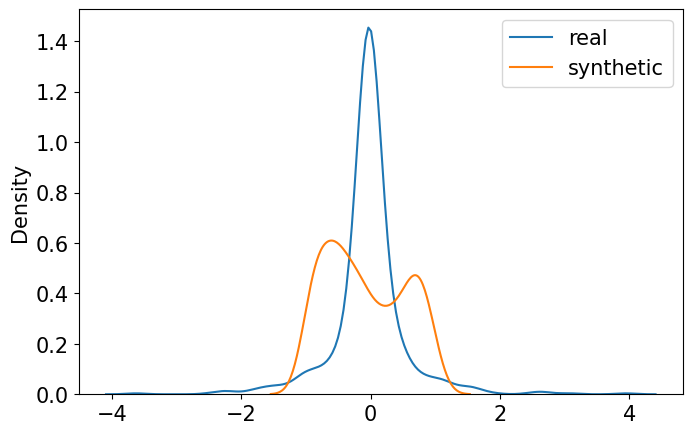

In [44]:
compare_plot(imp_feat0, df_syn0)

Disease class 1

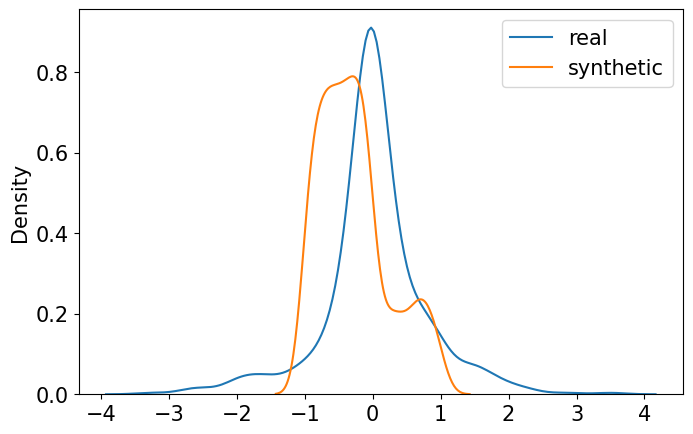

In [45]:
compare_plot(imp_feat1, df_syn1)

Disease class 2

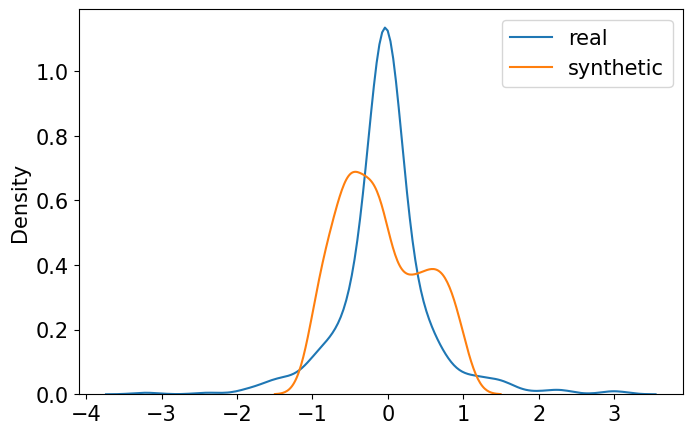

In [46]:
compare_plot(imp_feat2, df_syn2)

Disease class 3

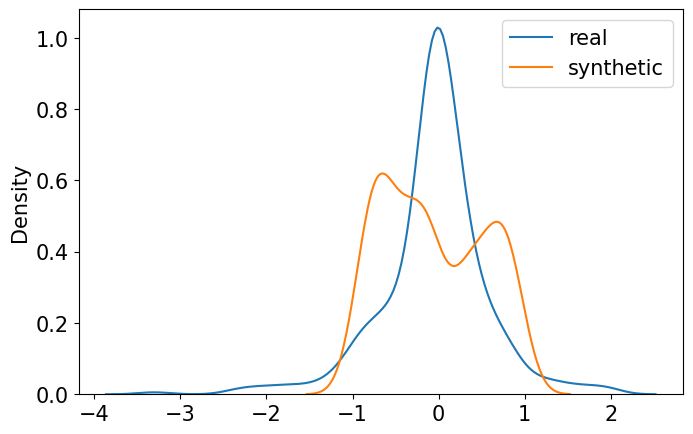

In [47]:
compare_plot(imp_feat3, df_syn3)

Disease class 4

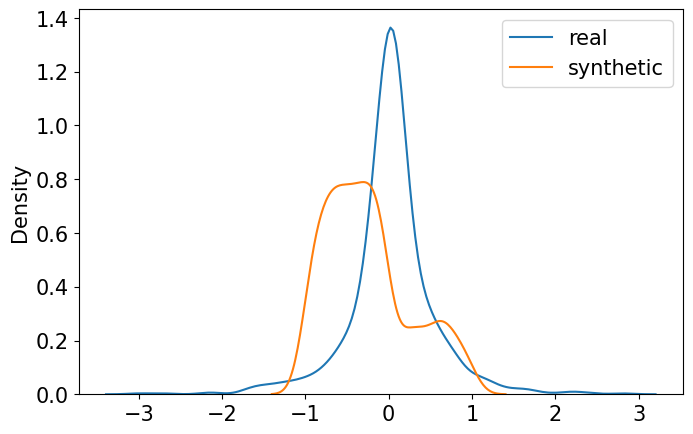

In [48]:
compare_plot(imp_feat4, df_syn4)

Disease class 5

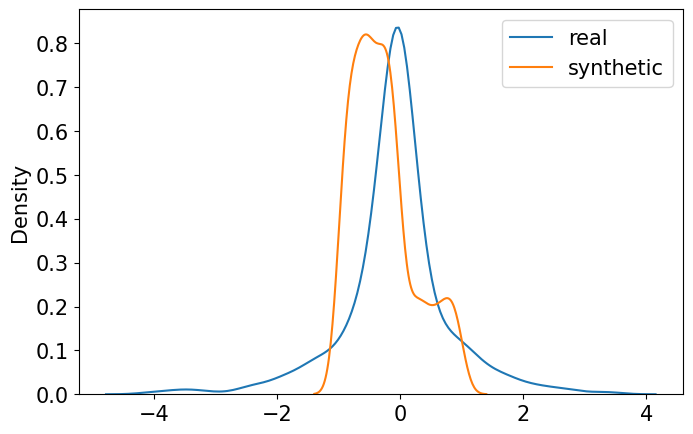

In [49]:
compare_plot(imp_feat5, df_syn5)

Disease class 6

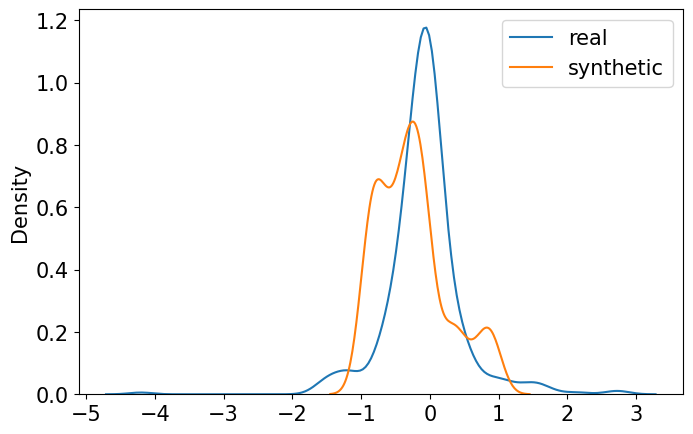

In [50]:
compare_plot(imp_feat6, df_syn6)

Disease class 7

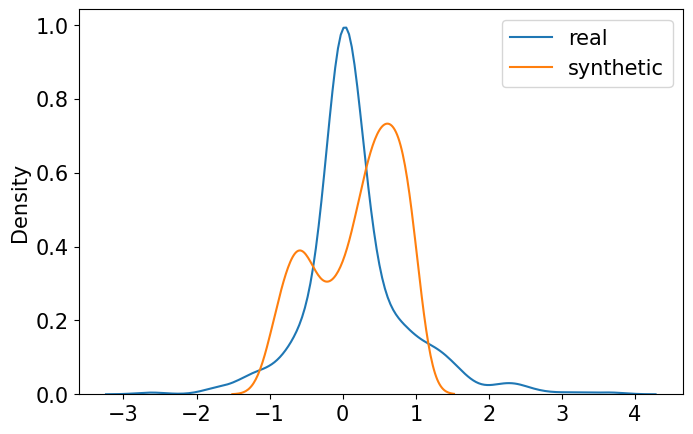

In [51]:
compare_plot(imp_feat7, df_syn7)

### Comparison of real and synthetic distributions for the most important feature

Disease class 0

Index of real important feature 193
Index of synthetic important feature [0]


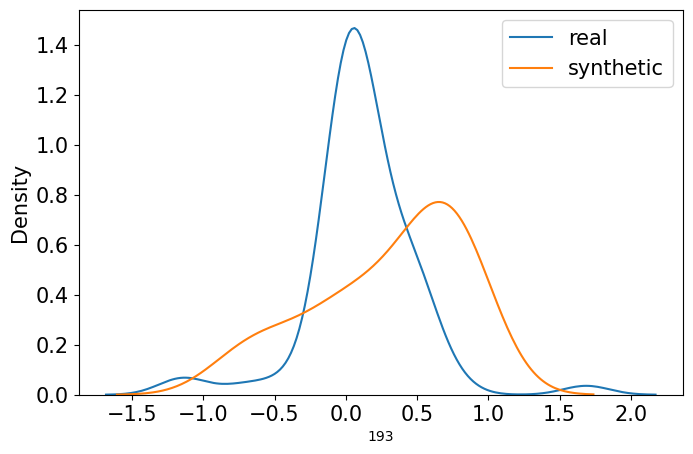

In [92]:
print('Index of real important feature',real_ind0)
corr = df_syn0.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.25).any()
syn_0 = corr.loc[m]
syn_ind0 = syn_0.index
print('Index of synthetic important feature',np.ravel(syn_ind0))
compare_plot(disease_class0[real_ind0], df_syn0[syn_ind0])

Disease class 1

Index of real important feature 6
Index of synthetic important feature [4]


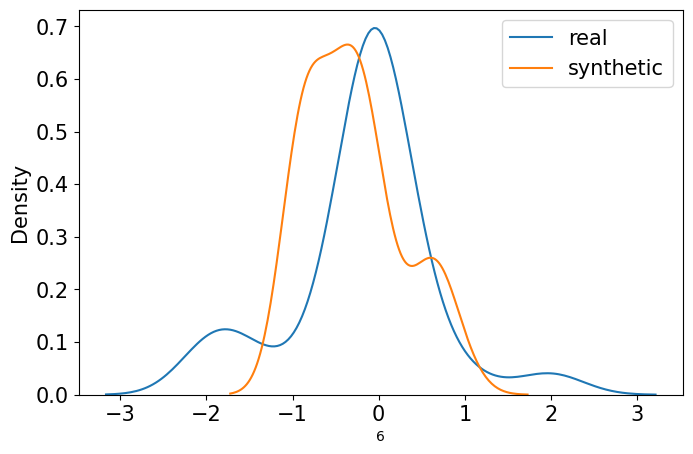

In [93]:
print('Index of real important feature',real_ind1)
corr = df_syn1.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.17).any()
syn_1 = corr.loc[m]
syn_ind1 = syn_1.index
print('Index of synthetic important feature',np.ravel(syn_ind1))
compare_plot(disease_class1[real_ind1], df_syn1[syn_ind1])

Disease class 2

Index of real important feature 17
Index of synthetic important feature [0]


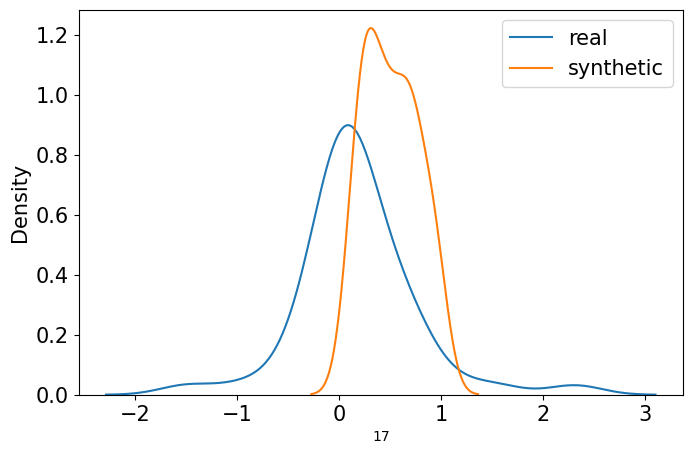

In [94]:
print('Index of real important feature',real_ind2)
corr = df_syn2.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.195).any()
syn_2 = corr.loc[m]
syn_ind2 = syn_2.index
print('Index of synthetic important feature',np.ravel(syn_ind2))
compare_plot(disease_class2[real_ind2], df_syn2[syn_ind2])

Disease class 3

Index of real important feature 149
Index of synthetic important feature [6]


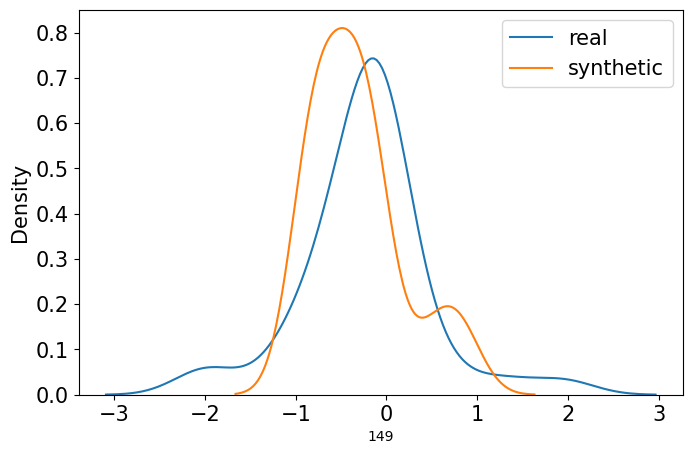

In [95]:
print('Index of real important feature',real_ind3)
corr = df_syn3.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.22).any()
syn_3 = corr.loc[m]
syn_ind3 = syn_3.index
print('Index of synthetic important feature',np.ravel(syn_ind3))
compare_plot(disease_class3[real_ind3], df_syn3[syn_ind3])

Disease class 4

Index of real important feature 73
Index of synthetic important feature [1]


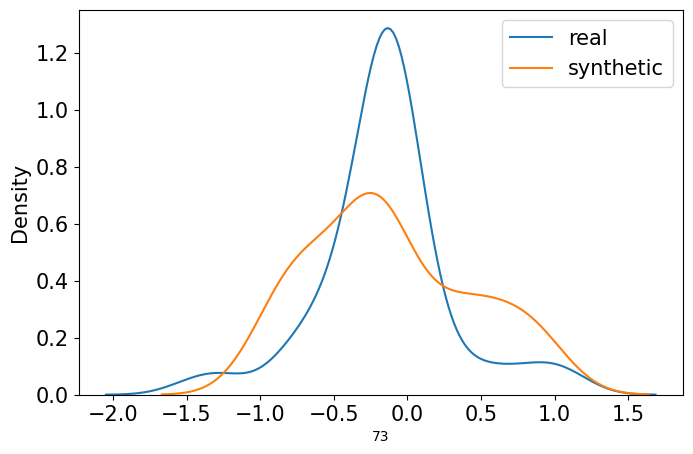

In [96]:
print('Index of real important feature',real_ind4)
corr = df_syn4.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.2).any()
syn_4 = corr.loc[m]
syn_ind4 = syn_4.index
print('Index of synthetic important feature',np.ravel(syn_ind4))
compare_plot(disease_class4[real_ind4], df_syn4[syn_ind4])

Disease class 5

Index of real important feature 159
Index of synthetic important feature [8]


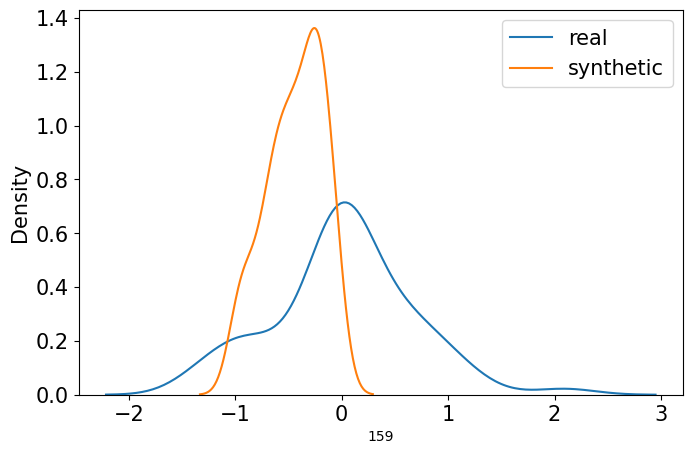

In [97]:
print('Index of real important feature',real_ind5)
corr = df_syn5.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.1).any()
syn_5 = corr.loc[m]
syn_ind5 = syn_5.index
print('Index of synthetic important feature',np.ravel(syn_ind5))
compare_plot(disease_class5[real_ind5], df_syn5[syn_ind5])

Disease class 6

Index of real important feature 91
Index of synthetic important feature [8]


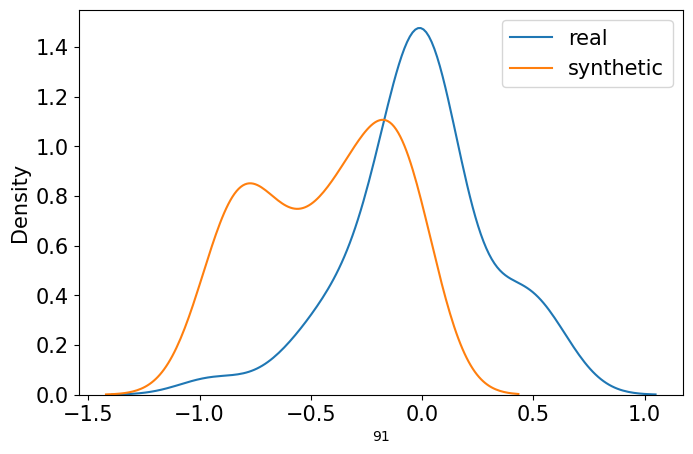

In [98]:
print('Index of real important feature',real_ind6)
corr = df_syn6.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.2).any()
syn_6 = corr.loc[m]
syn_ind6 = syn_6.index
print('Index of synthetic important feature',np.ravel(syn_ind6))
compare_plot(disease_class6[real_ind6], df_syn6[syn_ind6])

Disease class 7

Index of real important feature 46
Index of synthetic important feature [3]


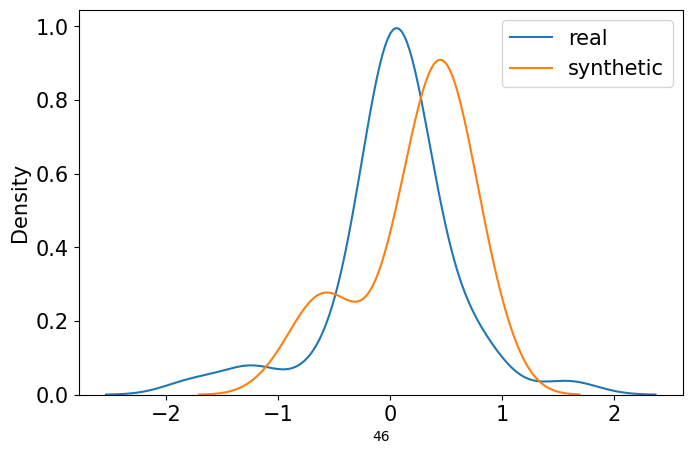

In [99]:
print('Index of real important feature',real_ind7)
corr = df_syn7.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.2).any()
syn_7 = corr.loc[m]
syn_ind7 = syn_7.index
print('Index of synthetic important feature',np.ravel(syn_ind7))
compare_plot(disease_class7[real_ind7], df_syn7[syn_ind7])

### Pairwise cosine similarity of all features for real and synthetic distributions

In [74]:
from sklearn.metrics.pairwise import cosine_similarity
def cosine_sim(original,sampled):
    return cosine_similarity(np.array(original), np.array(sampled))

Disease class 0

In [75]:
cosine_sim(imp_feat0, df_syn0)

array([[-0.21121112, -0.02600899, -0.14720481, ..., -0.14026224,
        -0.3851439 , -0.43604321],
       [ 0.57351101,  0.59575003,  0.04409727, ..., -0.198691  ,
         0.60607118,  0.04568951],
       [ 0.08235837, -0.19410949, -0.24981165, ..., -0.34524449,
        -0.4500845 , -0.6983907 ],
       ...,
       [ 0.17175859,  0.5806896 ,  0.06332686, ..., -0.23656628,
         0.22635367, -0.3433979 ],
       [-0.02329465, -0.10204948,  0.22781271, ..., -0.04077959,
        -0.12079512,  0.0127859 ],
       [ 0.1190399 ,  0.49235915,  0.16680983, ..., -0.38418597,
        -0.05584363, -0.56557644]])

<Axes: >

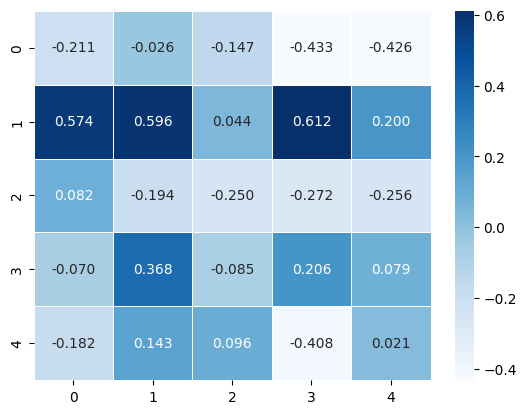

In [76]:
sns.heatmap(cosine_sim(imp_feat0[:5], df_syn0[:5]), 
            xticklabels = 1, yticklabels = 1, annot=True, cmap='Blues',fmt='.3f', linewidth=.5)

Disease class 1

In [77]:
cosine_sim(imp_feat1, df_syn1)

array([[-0.18473879, -0.06132869, -0.12788239, ..., -0.44914326,
        -0.16918699,  0.29553904],
       [-0.45115247,  0.47501025, -0.6024087 , ..., -0.18682398,
        -0.05142026, -0.41979654],
       [ 0.38609161, -0.23317876,  0.49608371, ..., -0.2993153 ,
        -0.71600885,  0.59115963],
       ...,
       [-0.4162911 ,  0.7225917 , -0.2297219 , ..., -0.0332812 ,
         0.03863618, -0.18692868],
       [-0.27783358, -0.19527183, -0.44620839, ..., -0.49850375,
        -0.31575182, -0.37215339],
       [-0.33722843,  0.56617646, -0.06914469, ...,  0.06252311,
         0.3202345 , -0.01029974]])

<Axes: >

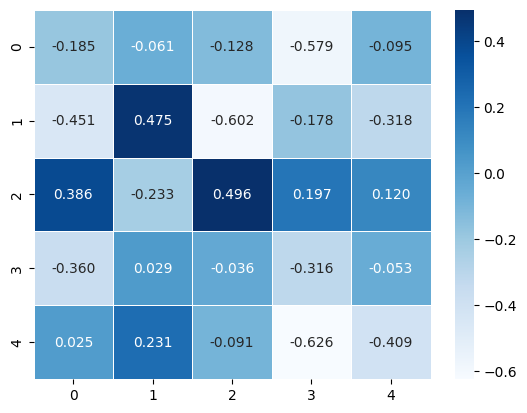

In [78]:
sns.heatmap(cosine_sim(imp_feat1[:5], df_syn1[:5]), 
            xticklabels = 1, yticklabels = 1, annot=True, cmap='Blues',fmt='.3f', linewidth=.5)

Disease class 2

In [79]:
cosine_sim(imp_feat2, df_syn2)

array([[-0.06180664,  0.19538313, -0.22975936, ...,  0.36123798,
        -0.19952058,  0.37104883],
       [-0.16847603, -0.19469607,  0.33982091, ..., -0.36263356,
        -0.26441315, -0.07444214],
       [-0.14529244, -0.08459146,  0.0404379 , ..., -0.23336715,
         0.11788348, -0.37186226],
       ...,
       [ 0.29946179,  0.09024498,  0.147602  , ...,  0.25636286,
         0.5533509 ,  0.04179736],
       [-0.298013  ,  0.06902477, -0.10436003, ..., -0.11015245,
         0.18800524, -0.14434427],
       [-0.14092922,  0.14644275, -0.05535134, ..., -0.35940634,
         0.20192496, -0.22956923]])

<Axes: >

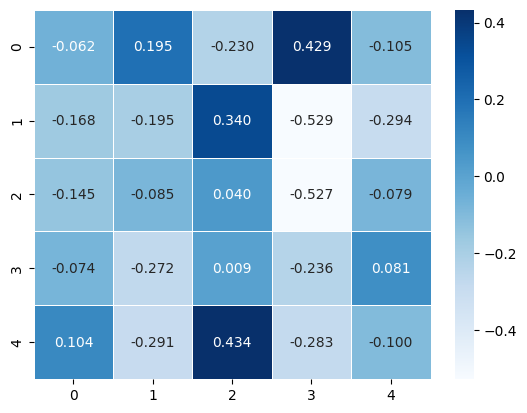

In [80]:
sns.heatmap(cosine_sim(imp_feat2[:5], df_syn2[:5]), 
            xticklabels = 1, yticklabels = 1, annot=True, cmap='Blues',fmt='.3f', linewidth=.5)

Disease class 3

In [81]:
cosine_sim(imp_feat3, df_syn3)

array([[-0.42480949, -0.23894883,  0.2707535 , ...,  0.29592617,
        -0.01742434, -0.43922527],
       [-0.14745571, -0.06820499,  0.52300232, ...,  0.37172246,
        -0.39033033, -0.12728873],
       [ 0.72049757,  0.68384272, -0.17203083, ...,  0.29174497,
         0.48158481,  0.57933704],
       ...,
       [-0.03957164, -0.15236111,  0.27110975, ..., -0.19373635,
        -0.02940215,  0.20941226],
       [ 0.00547514,  0.17490806, -0.28736889, ..., -0.14192832,
         0.01103412, -0.07146761],
       [ 0.42451232,  0.05525275,  0.29986217, ...,  0.34168677,
         0.42456696,  0.53688108]])

<Axes: >

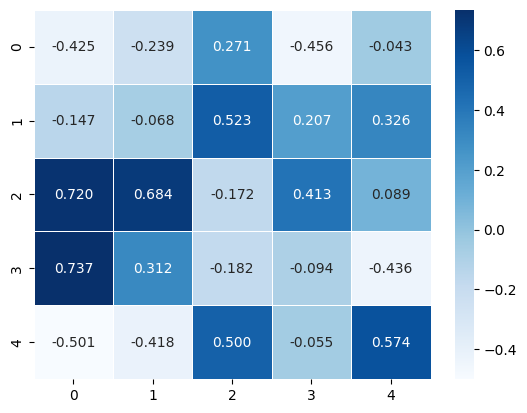

In [82]:
sns.heatmap(cosine_sim(imp_feat3[:5], df_syn3[:5]), 
            xticklabels = 1, yticklabels = 1, annot=True, cmap='Blues',fmt='.3f', linewidth=.5)

Disease class 4

In [83]:
cosine_sim(imp_feat4, df_syn4)

array([[ 0.4536137 , -0.08070412, -0.15239649, ..., -0.16586753,
        -0.26189533, -0.12012635],
       [ 0.17907973, -0.16135251, -0.13124999, ..., -0.09265234,
        -0.515133  , -0.58721386],
       [ 0.22743587, -0.17169098,  0.10966521, ..., -0.13008083,
        -0.19939013, -0.26216558],
       ...,
       [ 0.3460053 ,  0.25520588,  0.41456113, ..., -0.43052342,
         0.26151639, -0.03433744],
       [ 0.03502976,  0.21748662, -0.02029767, ..., -0.70154371,
        -0.06493213, -0.0177665 ],
       [ 0.69297923, -0.02963082,  0.03628371, ...,  0.18022075,
        -0.05063836, -0.47571473]])

<Axes: >

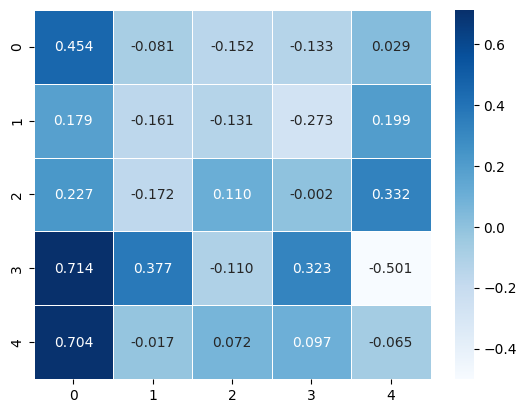

In [84]:
sns.heatmap(cosine_sim(imp_feat4[:5], df_syn4[:5]), 
            xticklabels = 1, yticklabels = 1, annot=True, cmap='Blues',fmt='.3f', linewidth=.5)

Disease class 5

In [85]:
cosine_sim(imp_feat5, df_syn5)

array([[-0.3025685 , -0.25400179, -0.13149641, ..., -0.40672038,
        -0.41294201, -0.21445305],
       [ 0.43291855,  0.3054711 ,  0.15435837, ...,  0.34238159,
         0.2694134 ,  0.37541589],
       [ 0.58501701,  0.55383548,  0.45837896, ...,  0.54250855,
         0.51325264,  0.3606521 ],
       ...,
       [ 0.19465935,  0.48840228,  0.43899205, ...,  0.61567928,
         0.2979854 ,  0.40689475],
       [-0.08868215, -0.39319575, -0.13869037, ..., -0.48592089,
        -0.41762883,  0.01809575],
       [-0.0598678 , -0.2077889 , -0.06527726, ..., -0.19029381,
        -0.25496326,  0.11228079]])

<Axes: >

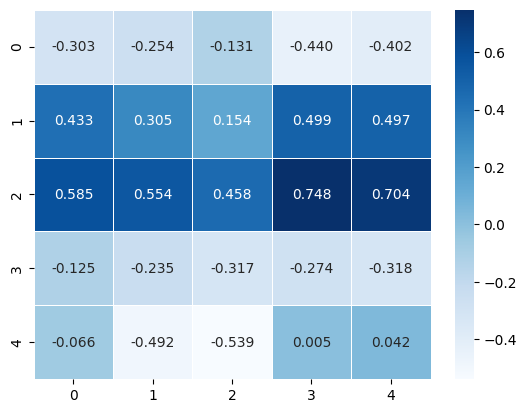

In [86]:
sns.heatmap(cosine_sim(imp_feat5[:5], df_syn5[:5]), 
            xticklabels = 1, yticklabels = 1, annot=True, cmap='Blues',fmt='.3f', linewidth=.5)

Disease class 6

In [87]:
cosine_sim(imp_feat6, df_syn6)

array([[-0.01310402, -0.06665891,  0.12260827, ..., -0.07204891,
         0.20414259,  0.18250404],
       [ 0.29656684, -0.0692027 ,  0.08688078, ...,  0.18216335,
         0.00491908, -0.12000771],
       [ 0.33030731,  0.32133866,  0.27280408, ...,  0.12600931,
         0.39849645,  0.09955351],
       ...,
       [ 0.12356851,  0.09528599, -0.1579341 , ..., -0.20488671,
        -0.03002301, -0.03728324],
       [ 0.28877954,  0.25052276,  0.26578225, ...,  0.1997595 ,
         0.44457401,  0.19677357],
       [ 0.16334052, -0.40047977,  0.39715843, ...,  0.44386471,
         0.25205502, -0.35979468]])

<Axes: >

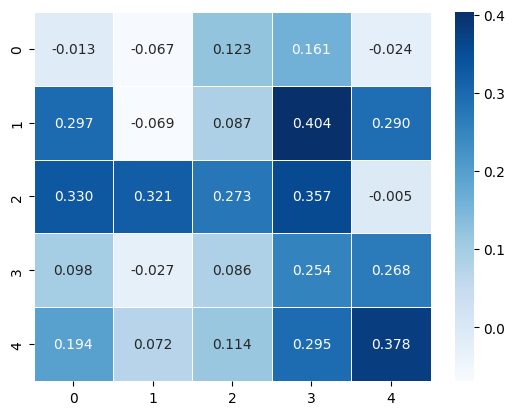

In [88]:
sns.heatmap(cosine_sim(imp_feat6[:5], df_syn6[:5]), 
            xticklabels = 1, yticklabels = 1, annot=True, cmap='Blues',fmt='.3f', linewidth=.5)

Disease class 7

In [89]:
cosine_sim(imp_feat7, df_syn7)

array([[ 0.32735948,  0.30955   ,  0.15766525, ..., -0.05988821,
        -0.0123528 , -0.39103215],
       [ 0.51684482,  0.360835  ,  0.50672578, ...,  0.36613618,
         0.55890043,  0.26038005],
       [-0.59329166, -0.27566474, -0.43677378, ..., -0.17256567,
        -0.77243323, -0.60373648],
       ...,
       [-0.04999843,  0.04717857,  0.33969449, ..., -0.09796299,
         0.22389447,  0.25286585],
       [ 0.01235041,  0.32040051, -0.10768351, ...,  0.20717766,
        -0.08195128,  0.19332788],
       [ 0.14681276,  0.68254446,  0.3431259 , ...,  0.55263181,
        -0.0130398 ,  0.1480504 ]])

<Axes: >

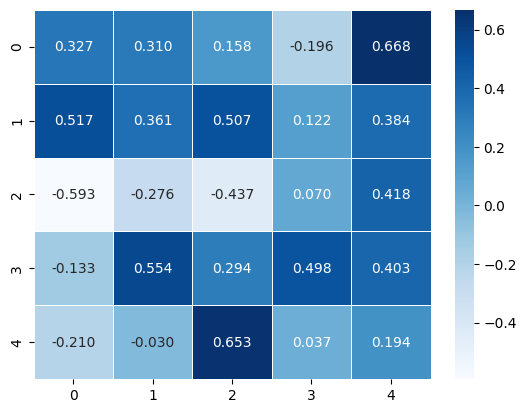

In [90]:
sns.heatmap(cosine_sim(imp_feat7[:5], df_syn7[:5]), 
            xticklabels = 1, yticklabels = 1, annot=True, cmap='Blues',fmt='.3f', linewidth=.5)